# Experimental Model Mark I: Tree-based

For reference: baseline tree-based (xgboost) TSNV model: f1-score \[0.86968 0.86063 0.82251 0.80255\] avg. 0.83884 on dev set

### Imports and reading dataset

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import os
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5633; Dev set size: 626; Testing set size: 696


In [3]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5633 entries, 5227 to 4753
Columns: 149 entries, MM00 to POTT24
dtypes: bool(20), float64(90), int32(29), int64(10)
memory usage: 5.1 MB


In [4]:
print("Null checking:")
print(dataset[dataset.isnull().any(axis=1)])

Null checking:
Empty DataFrame
Columns: [LOW_IMPACT, MID_IMPACT, BIG_IMPACT, DIRECT_STRIKE, MM00, DD00, MI_STATUS00, LI_STATUS00, SI_STATUS00, DS_STATUS00, DIST00, AZM00, SPEED00, DIR00, VMAX00, DVMAX00, ULVWS00, MLVWS00, HI_HUMID00, LO_HUMID00, STEMP00, UTEMP00, U_HK00, V_HK00, U20000, U50000, V50000, EASM00, VORT00, WESTERLY00, SH_AREA00, SH_INT00, SH_EXT00, POTT00, MM06, DD06, MI_STATUS06, LI_STATUS06, SI_STATUS06, DS_STATUS06, DIST06, AZM06, SPEED06, DIR06, VMAX06, DVMAX06, ULVWS06, MLVWS06, HI_HUMID06, LO_HUMID06, STEMP06, UTEMP06, U_HK06, V_HK06, U20006, U50006, V50006, EASM06, VORT06, WESTERLY06, SH_AREA06, SH_INT06, SH_EXT06, POTT06, MM12, DD12, MI_STATUS12, LI_STATUS12, SI_STATUS12, DS_STATUS12, DIST12, AZM12, SPEED12, DIR12, VMAX12, DVMAX12, ULVWS12, MLVWS12, HI_HUMID12, LO_HUMID12, STEMP12, UTEMP12, U_HK12, V_HK12, U20012, U50012, V50012, EASM12, VORT12, WESTERLY12, SH_AREA12, SH_INT12, SH_EXT12, POTT12, MM18, DD18, MI_STATUS18, LI_STATUS18, SI_STATUS18, DS_STATUS18, ...]
In

### Support functions

In [5]:
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_recall_curve, classification_report, f1_score, precision_score, recall_score, accuracy_score

In [6]:
def optimize_thresholds(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    # find the best decision thresholds and the corresponding F1 scores
    all_preds = np.array(clf.predict_proba(dataset_X))
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        if isinstance(clf, MultiOutputClassifier):
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[i,:,1])
        else:
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the last class/label
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

In [7]:
def predictions_with_thresholds(clf, thresholds, dataset_X):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = np.array(clf.predict_proba(dataset_X))
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    if isinstance(clf, MultiOutputClassifier):
        for i in range(preds_probs.shape[1]):
                pred_row = []
                for j in range(n_classes):
                    if preds_probs[j,i,1] > thresholds[j]:
                        pred_row.append(1)
                    else:
                        pred_row.append(0)
                preds.append(pred_row)
    else:
        for i in range(preds_probs.shape[0]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[i,j] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)        
    
    return np.array(preds)

In [8]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [9]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    if isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else regression_predict(clf, dataset_X)
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else regression_predict(clf, dataset_X)
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [10]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/experimental_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

### XGBoost Classifier

Without any hyperparameters provided, XGB Regressor: f1-score \[0.93443 0.90141 0.90000 0.87179\] average 0.90191  
Without any hyperparameters provided, XGB Classifier: f1-score \[0.93548 0.93671 0.89474 0.91892\] average 0.92146  
With params found by grid search, classifier: f1-score \[0.95082 0.96203 0.97436 0.94444\] average 0.95791

Interesting observations:
- The dataset is small, so it fitted absurdly quickly
- The dataset is small, so all scores were absurdly high
- The dataset is small, so the PR curves and calibration plots look awkward

Best Threshold=0.44700, F-Score=0.95935
Best Threshold=0.24275, F-Score=0.97500
Best Threshold=0.25802, F-Score=1.00000
Best Threshold=0.15740, F-Score=0.97297


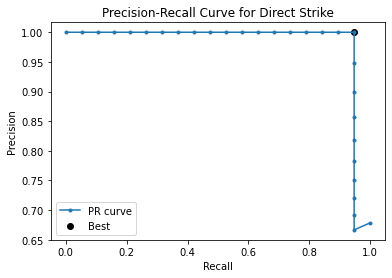

In [18]:
xgb_clf = MultiOutputClassifier(xgb.XGBClassifier(
    max_depth=5,subsample=1.0, colsample_bytree=0.5, min_child_weight=0.875, learning_rate=0.10625, reg_alpha=1e-5, reg_lambda=0.1,
    gamma=1e-5, n_estimators=200, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1).fit(train_X, train_Y)

best_thresholds, best_f1_scores = optimize_thresholds(xgb_clf, dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008955
Class 1, no calibration: 0.003785
Class 2, no calibration: 0.002283
Class 3, no calibration: 0.005452


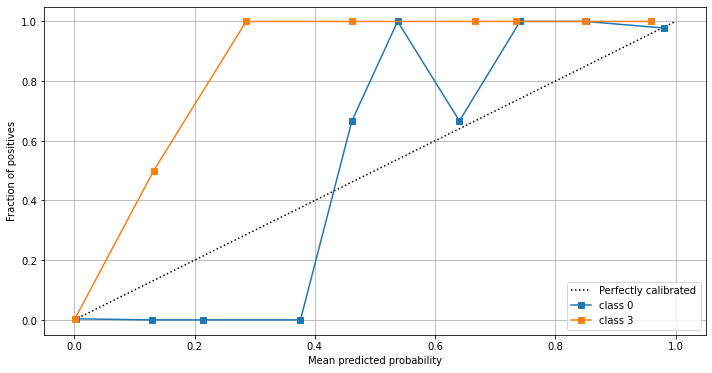

In [19]:
calibration_plot(xgb_clf, dev_X, dev_Y)

In [13]:
preds = predictions_with_thresholds(xgb_clf, best_thresholds, dev_X)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.95082   0.95082   0.95082        61
           1    0.95000   0.97436   0.96203        39
           2    1.00000   0.95000   0.97436        20
           3    1.00000   0.89474   0.94444        19

   micro avg    0.96350   0.94964   0.95652       139
   macro avg    0.97520   0.94248   0.95791       139
weighted avg    0.96439   0.94964   0.95648       139
 samples avg    0.09864   0.09771   0.09750       139



In [14]:
save_sklearn_model_to_file(xgb_clf, "gscv_xgb_clf")

### ExtraTreesClassifier

Because it worked pretty well for the baseline, maybe we can give another try.

No hyperparams given: f1-score \[0.94118 0.96203 0.92683 0.97297\] average 0.95075     
n_estimators=100, max_features=100, max_depth=25: f1-score \[0.95935 0.95000 0.92683 0.88235\] average 0.92963 

You see? It was worth it!

Best Threshold=0.32000, F-Score=0.96774
Best Threshold=0.47000, F-Score=0.96296
Best Threshold=0.36000, F-Score=0.95238
Best Threshold=0.28000, F-Score=0.91429


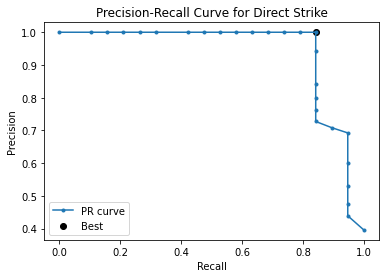

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = MultiOutputClassifier(ExtraTreesClassifier(
    n_estimators=100, max_features=100, max_depth=25,
    random_state=42, n_jobs=-1
), n_jobs=-1).fit(train_X, train_Y)

best_thresholds, best_f1_scores = optimize_thresholds(extra_trees_clf, dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008279
Class 1, no calibration: 0.007222
Class 2, no calibration: 0.005391
Class 3, no calibration: 0.008452


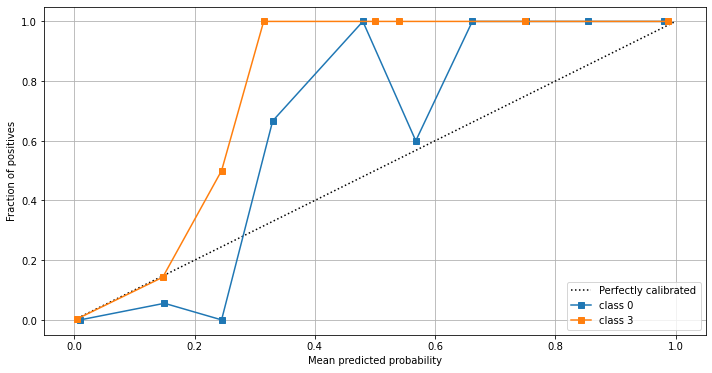

In [24]:
calibration_plot(extra_trees_clf, dev_X, dev_Y)

In [25]:
preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, dev_X)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.95161   0.96721   0.95935        61
           1    0.92683   0.97436   0.95000        39
           2    0.90476   0.95000   0.92683        20
           3    1.00000   0.78947   0.88235        19

   micro avg    0.94245   0.94245   0.94245       139
   macro avg    0.94580   0.92026   0.92963       139
weighted avg    0.94453   0.94245   0.94152       139
 samples avg    0.09651   0.09771   0.09633       139



In [26]:
save_sklearn_model_to_file(extra_trees_clf, "gscv_extra_trees_clf")

### AdaBoost Classifier

Added here solely for fun.

Baseline performance: f1-score \[0.62187 0.59971 0.50512 0.3318\] avg. 0.51464

This time: f1-score \[0.80000 0.79012 0.80000 0.69767\] average 0.77195

It got better, but the Brier scores are quite bad, so it might be less practical for us.

Best Threshold=0.49703, F-Score=0.80952
Best Threshold=0.49625, F-Score=0.80488
Best Threshold=0.49959, F-Score=0.83333
Best Threshold=0.48789, F-Score=0.72727


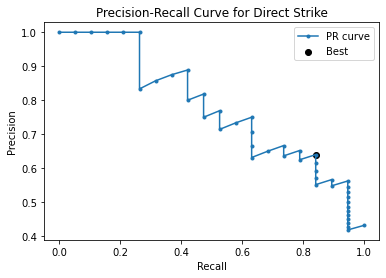

In [20]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_tc_clf = MultiOutputClassifier(AdaBoostClassifier(
    n_estimators=3000, 
    learning_rate=0.02
), n_jobs=-1)
adaboost_tc_clf.fit(train_X, train_Y)

best_thresholds, best_f1_scores = optimize_thresholds(adaboost_tc_clf, dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.208186
Class 1, no calibration: 0.205318
Class 2, no calibration: 0.188555
Class 3, no calibration: 0.183258


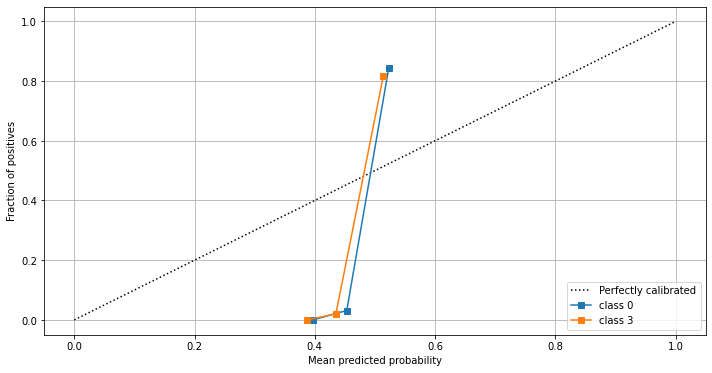

In [21]:
calibration_plot(adaboost_tc_clf, dev_X, dev_Y)

In [22]:
preds = predictions_with_thresholds(adaboost_tc_clf, best_thresholds, dev_X)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.78125   0.81967   0.80000        61
           1    0.76190   0.82051   0.79012        39
           2    0.93333   0.70000   0.80000        20
           3    0.62500   0.78947   0.69767        19

   micro avg    0.76552   0.79856   0.78169       139
   macro avg    0.77537   0.78241   0.77195       139
weighted avg    0.77635   0.79856   0.78324       139
 samples avg    0.08360   0.08280   0.07967       139



### Optimizing the ExtraTreesClassifier

max_features: from 20 to 140, best value 100  
max_depth: from 5 to 50, best value 25  
class_weight: "balanced", "balanced_subsample", None; best value None  
n_estimators: from 50 to 700, best value 100  

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {"estimator__n_estimators": [None, 100]}
estimator = MultiOutputClassifier(ExtraTreesClassifier(n_jobs=-1, random_state=42))

scorer = make_scorer(f1_score, zero_division=0, average='macro')

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, n_jobs=-1, verbose=4, cv=4, error_score=0.0, refit=False).fit(train_X, train_Y)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/multioutput.py", line 434, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/mu

In [15]:
gscv.cv_results_

{'mean_fit_time': array([4.31474531, 4.40655971]),
 'std_fit_time': array([0.18132644, 0.04850968]),
 'mean_score_time': array([0.74885291, 0.67449087]),
 'std_score_time': array([0.04876989, 0.04668822]),
 'param_estimator__max_depth': masked_array(data=[None, 25],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': None}, {'estimator__max_depth': 25}],
 'split0_test_score': array([0.77153757, 0.78081413]),
 'split1_test_score': array([0.83791139, 0.83049851]),
 'split2_test_score': array([0.71154814, 0.70847156]),
 'split3_test_score': array([0.70573868, 0.70727518]),
 'mean_test_score': array([0.75668395, 0.75676485]),
 'std_test_score': array([0.05350511, 0.05195308]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [16]:
gscv.best_params_

{'estimator__max_depth': 25}

### Optimizing the XGBoost Classifier

max_depth: from 2-30, best value 5  
subsample: from 0.25-1.0, best value 1.0   
colsample_bytree: from 0.25-1.0, best value 0.5   
min_child_weight: from 0.25-2.0, best value 0.875   
learning_rate: from 0.001-0.2, best value 0.10625   
reg_alpha: from 1.0-1e-5, best value 1e-5  
reg_lambda: from 1e-5-1.0, best value 0.1   
gamma: from 0.00001-1.0, best value 1e-5   
n_estimators: from 100-500, best value 200 

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

xgb_clf = MultiOutputClassifier(xgb.XGBClassifier(
    subsample=1.0, colsample_bytree=0.5, min_child_weight=0.875, learning_rate=0.10625, reg_alpha=1e-5, reg_lambda=0.1,
    gamma=1e-5, n_estimators=200, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)

scorer = make_scorer(f1_score, zero_division=0, average='macro')

param_grid = {"estimator__max_depth": [2,3,4,5]}

gscv = GridSearchCV(xgb_clf, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=1).fit(train_X, train_Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ............estimator__max_depth=2;, score=0.726 total time=   1.6s
[CV 2/3] END ............estimator__max_depth=2;, score=0.708 total time=   1.6s
[CV 3/3] END ............estimator__max_depth=2;, score=0.718 total time=   1.7s
[CV 1/3] END ............estimator__max_depth=3;, score=0.777 total time=   1.9s
[CV 2/3] END ............estimator__max_depth=3;, score=0.749 total time=   2.0s
[CV 3/3] END ............estimator__max_depth=3;, score=0.776 total time=   2.0s
[CV 1/3] END ............estimator__max_depth=4;, score=0.781 total time=   2.4s
[CV 2/3] END ............estimator__max_depth=4;, score=0.808 total time=   2.5s
[CV 3/3] END ............estimator__max_depth=4;, score=0.807 total time=   2.5s
[CV 1/3] END ............estimator__max_depth=5;, score=0.797 total time=   2.8s
[CV 2/3] END ............estimator__max_depth=5;, score=0.795 total time=   2.8s
[CV 3/3] END ............estimator__max_depth=5;,

In [92]:
gscv.cv_results_

{'mean_fit_time': array([1.32399615, 1.61831156, 2.06056054, 2.42300193]),
 'std_fit_time': array([0.00419403, 0.01475792, 0.03101569, 0.03250762]),
 'mean_score_time': array([0.31605053, 0.35307924, 0.36767602, 0.41836087]),
 'std_score_time': array([0.0245289 , 0.00621629, 0.0456366 , 0.00549643]),
 'param_estimator__max_depth': masked_array(data=[2, 3, 4, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': 2},
  {'estimator__max_depth': 3},
  {'estimator__max_depth': 4},
  {'estimator__max_depth': 5}],
 'split0_test_score': array([0.72596069, 0.77701592, 0.78125316, 0.79659387]),
 'split1_test_score': array([0.70767539, 0.74886015, 0.80759789, 0.79459605]),
 'split2_test_score': array([0.71798531, 0.77606043, 0.80658984, 0.81426909]),
 'mean_test_score': array([0.71720713, 0.76731217, 0.7984803 , 0.80181967]),
 'std_test_score': array([0.00748519, 0.01305338, 0.01218838, 0.00884077]),
 'rank_te

In [93]:
gscv.best_params_

{'estimator__max_depth': 5}

### Probability Calibration

See the corresponding section under sktime notebook for my comments.

For the love of, um, [Akina Nakamori](https://www.youtube.com/playlist?list=PL2wNvj-Fcy0J00jBq9EjSQJWxTcNaaKVJ), this isn't really going anywhere.

In [15]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

# base estimator
xgb_clf = OneVsRestClassifier(xgb.XGBClassifier(
    max_depth=5,subsample=1.0, colsample_bytree=0.5, min_child_weight=0.875, learning_rate=0.10625, reg_alpha=1e-5, reg_lambda=0.1,
    gamma=1e-5, n_estimators=200, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)
# calibrated estimator
xgb_clf = CalibratedClassifierCV(base_estimator=xgb_clf, cv=7, n_jobs=-1, ensemble=False)
xgb_clf = MultiOutputClassifier(xgb_clf, n_jobs=-1).fit(train_X, train_Y)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008212
Class 1, no calibration: 0.003208
Class 2, no calibration: 0.000823
Class 3, no calibration: 0.003494


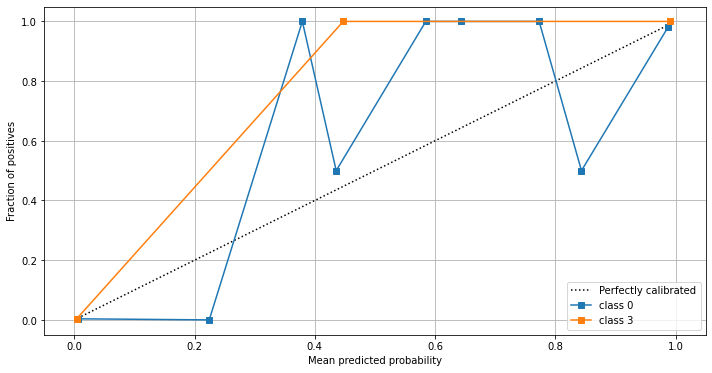

In [16]:
calibration_plot(xgb_clf, dev_X, dev_Y)

Best Threshold=0.37934, F-Score=0.95935
Best Threshold=0.07244, F-Score=0.97500
Best Threshold=0.31231, F-Score=1.00000
Best Threshold=0.06713, F-Score=0.97297
              precision    recall  f1-score   support

           0    0.95082   0.95082   0.95082        61
           1    0.95000   0.97436   0.96203        39
           2    1.00000   0.95000   0.97436        20
           3    1.00000   0.89474   0.94444        19

   micro avg    0.96350   0.94964   0.95652       139
   macro avg    0.97520   0.94248   0.95791       139
weighted avg    0.96439   0.94964   0.95648       139
 samples avg    0.09864   0.09771   0.09750       139



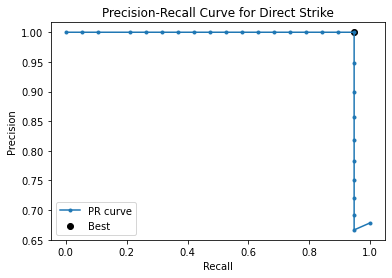

In [17]:
best_thresholds, best_f1_scores = optimize_thresholds(xgb_clf, dev_X, dev_Y)
preds = predictions_with_thresholds(xgb_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [18]:
save_sklearn_model_to_file(xgb_clf, "calibrated_gscv_xgb_clf")

#### The same but for extra trees

In [27]:
# base estimator
clf = OneVsRestClassifier(ExtraTreesClassifier(
    n_estimators=100, max_features=100, max_depth=25,
    random_state=42, n_jobs=-1
), n_jobs=-1)
# calibrated estimator
clf = CalibratedClassifierCV(base_estimator=clf, cv=7, n_jobs=-1, ensemble=False)
clf = MultiOutputClassifier(clf, n_jobs=-1).fit(train_X, train_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.006363
Class 1, no calibration: 0.005319
Class 2, no calibration: 0.002581
Class 3, no calibration: 0.007167


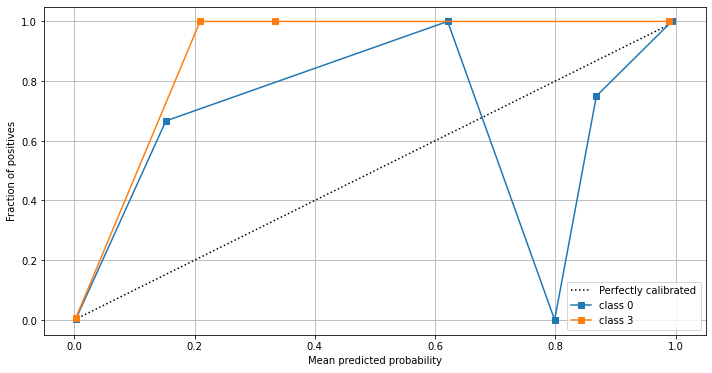

In [28]:
calibration_plot(clf, dev_X, dev_Y)

Best Threshold=0.13371, F-Score=0.96774
Best Threshold=0.68536, F-Score=0.96296
Best Threshold=0.40297, F-Score=0.95238
Best Threshold=0.20921, F-Score=0.91429
              precision    recall  f1-score   support

           0    0.95161   0.96721   0.95935        61
           1    0.92683   0.97436   0.95000        39
           2    0.90476   0.95000   0.92683        20
           3    1.00000   0.78947   0.88235        19

   micro avg    0.94245   0.94245   0.94245       139
   macro avg    0.94580   0.92026   0.92963       139
weighted avg    0.94453   0.94245   0.94152       139
 samples avg    0.09651   0.09771   0.09633       139



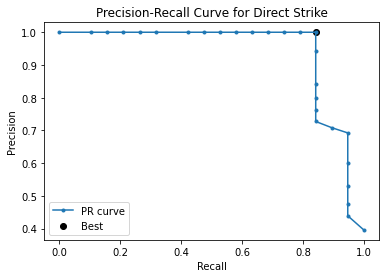

In [29]:
best_thresholds, best_f1_scores = optimize_thresholds(clf, dev_X, dev_Y)
preds = predictions_with_thresholds(clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [31]:
save_sklearn_model_to_file(clf, "calibrated_gscv_extra_trees_clf")

## Regressors
As an afterthought during report writing, hopefully worth the effort

### XGB Regressor, grid searched

In [69]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve

param_grid = {"estimator__max_depth": [5, 10, 15, 20, 25]}

estimator = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=300, colsample_bytree=0.125, subsample=1.0, learning_rate=0.125, reg_alpha=0.625, 
    reg_lambda=1.0, gamma=5e-5, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')

scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=-1, refit=False).fit(train_X, train_Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

In [70]:
print(gscv.cv_results_)
print(gscv.best_params_)

{'mean_fit_time': array([ 33.29153093,  39.02687391,  40.85731888,  42.40937408,
       241.96988297]), 'std_fit_time': array([ 0.32386857,  0.8476963 ,  8.95600344,  1.14822963, 43.9700365 ]), 'mean_score_time': array([0.30570404, 0.33467786, 0.41245675, 0.35566807, 0.14788175]), 'std_score_time': array([0.01734596, 0.06903455, 0.10365783, 0.03608508, 0.1053803 ]), 'param_estimator__max_depth': masked_array(data=[5, 10, 15, 20, 25],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'estimator__max_depth': 5}, {'estimator__max_depth': 10}, {'estimator__max_depth': 15}, {'estimator__max_depth': 20}, {'estimator__max_depth': 25}], 'split0_test_score': array([0.89032178, 0.89115249, 0.8945559 , 0.88605036, 0.88173667]), 'split1_test_score': array([0.84171908, 0.84631938, 0.83634464, 0.85149407, 0.84954947]), 'split2_test_score': array([0.85239083, 0.83520944, 0.83939212, 0.82996075,        nan]), 'mean_test_score': array([

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

Best Threshold=0.44714, F-Score=0.95082
Best Threshold=0.39379, F-Score=0.98734
Best Threshold=0.27891, F-Score=0.93023
Best Threshold=0.22038, F-Score=0.94737
              precision    recall  f1-score   support

           0    0.95000   0.93443   0.94215        61
           1    0.97436   0.97436   0.97436        39
           2    0.86364   0.95000   0.90476        20
           3    0.94444   0.89474   0.91892        19

   micro avg    0.94245   0.94245   0.94245       139
   macro avg    0.93311   0.93838   0.93505       139
weighted avg    0.94365   0.94245   0.94263       139
 samples avg    0.09651   0.09665   0.09583       139

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.013933
Class 1, no calibration: 0.008466
Class 2, no calibration: 0.008017
Class 3, no calibration: 0.008191


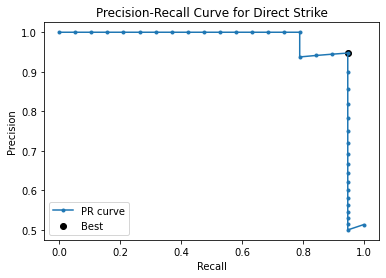

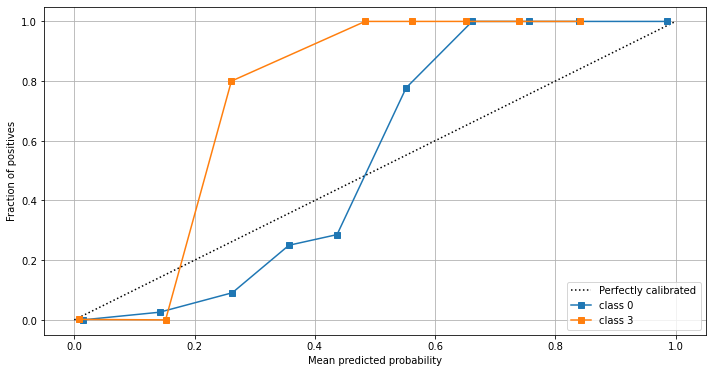

In [71]:
xgb_regr = MultiOutputRegressor(xgb.XGBRegressor(
    max_depth=5, colsample_bytree=0.125, subsample=1.0, learning_rate=0.125, reg_alpha=0.625, n_estimators=300,
    reg_lambda=1.0, gamma=5e-5, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1).fit(train_X, train_Y)

best_thresholds, best_f1_scores = regressor_find_thresholds(xgb_regr, dev_X, dev_Y)

preds = regression_label(xgb_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

calibration_plot(xgb_regr, dev_X, dev_Y)

In [72]:
save_sklearn_model_to_file(xgb_regr, "gscv_xgb_regr")

### Extra Trees

In [34]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve

param_grid = {"estimator__max_depth": [5,10,15,20,25,30]}

estimator = MultiOutputRegressor(ExtraTreesRegressor(
    n_estimators=290, max_features=65, n_jobs=-1, random_state=42
), n_jobs=-1)

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')

scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=-1, refit=False).fit(train_X, train_Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [35]:
gscv.cv_results_

{'mean_fit_time': array([10.33111095, 16.24917348, 17.88182052, 17.69202892, 16.06636453,
        15.3179396 ]),
 'std_fit_time': array([0.14730129, 0.40966124, 0.56712095, 0.63510536, 0.30052516,
        0.22996878]),
 'mean_score_time': array([0.74924882, 0.94603896, 1.02607075, 0.84387541, 0.83530211,
        1.03094776]),
 'std_score_time': array([0.02579229, 0.14589663, 0.11689388, 0.02248726, 0.06876455,
        0.27271435]),
 'param_estimator__max_depth': masked_array(data=[5, 10, 15, 20, 25, 30],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': 5},
  {'estimator__max_depth': 10},
  {'estimator__max_depth': 15},
  {'estimator__max_depth': 20},
  {'estimator__max_depth': 25},
  {'estimator__max_depth': 30}],
 'split0_test_score': array([0.62400638, 0.82962078, 0.87723297, 0.87951799, 0.88006568,
        0.8789195 ]),
 'split1_test_score': array([0.59346935, 0.82343029, 0.8783522

In [36]:
gscv.best_params_

{'estimator__max_depth': 20}

Best Threshold=0.34483, F-Score=0.96721
Best Threshold=0.47204, F-Score=0.96296
Best Threshold=0.30000, F-Score=0.95238
Best Threshold=0.28276, F-Score=0.91429
              precision    recall  f1-score   support

           0    0.96667   0.95082   0.95868        61
           1    0.92683   0.97436   0.95000        39
           2    0.90476   0.95000   0.92683        20
           3    1.00000   0.78947   0.88235        19

   micro avg    0.94891   0.93525   0.94203       139
   macro avg    0.94956   0.91616   0.92946       139
weighted avg    0.95114   0.93525   0.94123       139
 samples avg    0.09518   0.09611   0.09495       139

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.009245
Class 1, no calibration: 0.007044
Class 2, no calibration: 0.006212
Class 3, no calibration: 0.008586


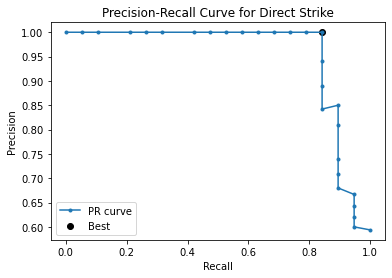

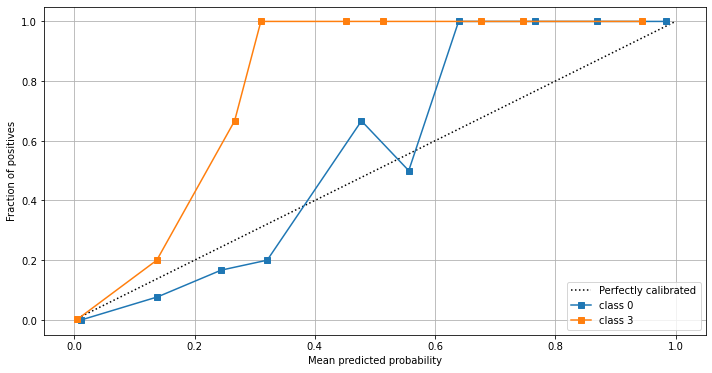

In [37]:
extra_trees_regr = MultiOutputRegressor(ExtraTreesRegressor(
    n_estimators=290, max_depth=20, max_features=65, n_jobs=-1, random_state=42
), n_jobs=-1).fit(train_X, train_Y)

best_thresholds, best_f1_scores = regressor_find_thresholds(extra_trees_regr, dev_X, dev_Y)

preds = regression_label(extra_trees_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

calibration_plot(extra_trees_regr, dev_X, dev_Y)

In [38]:
save_sklearn_model_to_file(extra_trees_regr, "gscv_extra_trees_regr")

[CV 1/3] END ...........estimator__max_depth=10;, score=0.764 total time=  45.7s
[CV 1/3] END .............estimator__max_depth=25;, score=nan total time=  11.0s
[CV 3/3] END ............estimator__max_depth=5;, score=0.769 total time=  30.4s
[CV 2/3] END ............estimator__max_depth=5;, score=0.587 total time=   7.8s
[CV 3/3] END ...........estimator__max_depth=15;, score=0.856 total time=   7.6s
[CV 3/3] END ........estimator__max_features=40;, score=0.870 total time=   4.6s
[CV 3/3] END ........estimator__max_features=80;, score=0.867 total time=   6.3s
[CV 2/3] END ........estimator__max_features=65;, score=0.890 total time=   6.4s
[CV 3/3] END ........estimator__max_features=80;, score=0.867 total time=   6.4s
[CV 3/3] END .......estimator__n_estimators=100;, score=0.885 total time=   6.2s
[CV 3/3] END .......estimator__n_estimators=200;, score=0.891 total time=   9.8s
[CV 2/3] END .......estimator__n_estimators=300;, score=0.891 total time=  18.0s
[CV 1/3] END .......estimato

[CV 2/3] END ............estimator__max_depth=5;, score=0.743 total time=  30.3s
[CV 3/3] END .............estimator__max_depth=15;, score=nan total time=  31.9s
[CV 2/3] END .............estimator__max_depth=10;, score=nan total time=  42.0s
[CV 1/3] END ...........estimator__max_depth=10;, score=0.850 total time=  11.3s
[CV 1/3] END ........estimator__max_features=20;, score=0.889 total time=   3.6s
[CV 3/3] END ........estimator__max_features=60;, score=0.880 total time=   5.7s
[CV 2/3] END ........estimator__max_features=60;, score=0.879 total time=   6.4s
[CV 3/3] END ........estimator__max_features=75;, score=0.871 total time=   6.4s
[CV 1/3] END .......estimator__n_estimators=150;, score=0.874 total time=   9.2s
[CV 1/3] END .......estimator__n_estimators=250;, score=0.878 total time=  15.7s
[CV 2/3] END .......estimator__n_estimators=400;, score=0.889 total time=  20.3s
[CV 3/3] END .......estimator__n_estimators=250;, score=0.892 total time=  15.8s
[CV 2/3] END .......estimato